# Projekt IUM

## Ogólne informacje

Realizujący:
* Tomasz Słojewski
* Anton Masiukevich

Dane otrzymane:
* Baza użytkowników ("users.json")
* Katalog produktów ("delivery.json")
* Historia sesji ("sessions.json")
* Dostawy produktów ("deliveries.json")

In [1]:
import pandas as pd
import numpy as np
import itertools
import hashlib

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import tensorflow as tf

## Ustawienie ziarna

In [2]:
np.random.seed(0)

## Wczytujemy przygotowane dane

In [3]:
processed_data = pd.read_csv('processed_data.csv')
processed_data

,Unnamed: 0,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
1,1,102,Warszawa,2021,3,157.0,31.0,0.0,15647.7045,NaN
2,3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
3,12,102,Warszawa,2020,2,0.0,0.0,0.0,0.0000,NaN
4,13,102,Warszawa,2020,3,0.0,0.0,0.0,0.0000,NaN
...,...,...,...,...,...,...,...,...,...,...
2795,4795,301,Police,2020,10,0.0,0.0,0.0,0.0000,NaN
2796,4796,301,Police,2020,9,0.0,0.0,0.0,0.0000,NaN
2797,4797,301,Police,2020,4,0.0,0.0,0.0,0.0000,NaN
2798,4798,301,Police,2020,6,0.0,0.0,0.0,0.0000,NaN


# Uczenie

### Wybranie danych nadających się do uczenia

In [4]:
data_to_learning = processed_data.dropna(subset=['next_months_sum'])
data_to_learning

,Unnamed: 0,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
2,3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
14,24,103,Gdynia,2021,2,49.0,7.0,0.0,1997.3910,64.8000
16,27,103,Gdynia,2021,1,4.0,2.0,0.0,662.0000,1997.3910
20,40,103,Gdynia,2020,11,0.0,0.0,0.0,0.0000,40.4910
...,...,...,...,...,...,...,...,...,...,...
2764,4744,299,Konin,2020,11,0.0,0.0,0.0,0.0000,3587.3640
2772,4752,300,Gdynia,2021,2,103.0,18.0,0.0,10594.7025,13013.6235
2774,4755,300,Gdynia,2021,1,0.0,0.0,0.0,0.0000,10594.7025
2786,4776,301,Police,2021,2,176.0,29.0,0.0,12518.7370,11226.4535


### Rozdzielenie danych na zbiór uczący i testowy

In [5]:
msk = np.random.rand(len(data_to_learning)) < 0.8
train = data_to_learning[msk]
test = data_to_learning[~msk]
print(test)
train

      Unnamed: 0  user_id    city  year  month  total_web_events  \
38            68      104  Police  2020      9               4.0   
39            69      104  Police  2020      4              22.0   
58            99      106  Mielec  2021      1               0.0   
76           136      107  Police  2020     11               0.0   
78           138      107  Police  2020      7              29.0   
...          ...      ...     ...   ...    ...               ...   
2737        4697      297  Mielec  2020      5              33.0   
2741        4701      297  Mielec  2020      4              13.0   
2746        4707      298  Gdynia  2021      1               9.0   
2748        4717      298  Gdynia  2020      3              44.0   
2757        4727      298  Gdynia  2020      8              18.0   

      buying_events  num_dropped_monthly  sum_after_discount  next_months_sum  
38              0.0                  0.0               0.000          141.683  
39              3.0    

,Unnamed: 0,user_id,city,year,month,total_web_events,buying_events,num_dropped_monthly,sum_after_discount,next_months_sum
0,0,102,Warszawa,2021,2,143.0,21.0,0.0,8860.9985,15647.7045
2,3,102,Warszawa,2021,1,0.0,0.0,0.0,0.0000,8860.9985
14,24,103,Gdynia,2021,2,49.0,7.0,0.0,1997.3910,64.8000
16,27,103,Gdynia,2021,1,4.0,2.0,0.0,662.0000,1997.3910
20,40,103,Gdynia,2020,11,0.0,0.0,0.0,0.0000,40.4910
...,...,...,...,...,...,...,...,...,...,...
2764,4744,299,Konin,2020,11,0.0,0.0,0.0,0.0000,3587.3640
2772,4752,300,Gdynia,2021,2,103.0,18.0,0.0,10594.7025,13013.6235
2774,4755,300,Gdynia,2021,1,0.0,0.0,0.0,0.0000,10594.7025
2786,4776,301,Police,2021,2,176.0,29.0,0.0,12518.7370,11226.4535


## Uczenie modelu - model liniowy - jenda zmienna z wizualizacją

### Przygotowanie wejścia/wyjścia

In [6]:
inputs_train = train.dropna(subset=['next_months_sum'])
# x = inputs[['user_id', 'year', 'month', 'total_web_events','buying_events', 'num_dropped_monthly', 'sum_after_discount']].values
x = inputs_train[['sum_after_discount']].values
y = train.next_months_sum.values

inputs_tests = test.dropna(subset=['next_months_sum'])
x_test = inputs_tests[['sum_after_discount']].values
y_test = test.next_months_sum.values

### Trenowanie modelu

In [7]:
slr_sv = LinearRegression()
slr_sv.fit(x, y)

LinearRegression()

### Wizualizacja

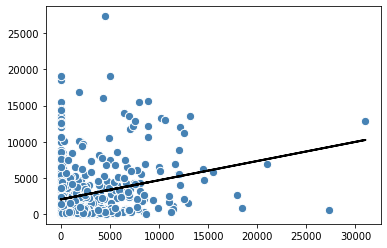

błąd doapsowania do danych uczących: 2360.5650413267163
błąd dopasowania do danych testowych:  2226.401412012742


In [8]:
# wizualizacja
def lin_regplot(x, y, model):
    plt.scatter(x, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(x, model.predict(x), color='black', lw=2)

lin_regplot(x, y, slr_sv)
plt.show()

print("błąd doapsowania do danych uczących:", mean_absolute_error(y, slr_sv.predict(x)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, slr_sv.predict(x_test)))

## Uczenie modelu - model liniowy - wszystkie zmienne

### Przygotowanie danych

In [9]:
inputs_train = train.dropna(subset=['next_months_sum'])
columns = inputs_train.columns
columns = columns.drop('next_months_sum')
columns = columns.drop('city')
x = inputs_train[columns].values
y = train.next_months_sum.values

inputs_tests = test.dropna(subset=['next_months_sum'])
columns = inputs_train.columns # - ['next_months_sum', 'city']
columns = columns.drop('next_months_sum')
columns = columns.drop('city')
x_test = inputs_tests[columns].values
y_test = test.next_months_sum.values

### Trenowanie modelu

In [10]:
slr = LinearRegression()
slr.fit(x, y)
#slr.predict(x_test)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, slr.predict(x)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, slr.predict(x_test)))

błąd doapsowania do danych uczących: 2236.25014625736
błąd dopasowania do danych testowych:  2072.1819912708143


## Uczenie modelu - model kwadratowy

### Przygotowanie danych

In [11]:
inputs_train = train.dropna(subset=['next_months_sum'])
columns = inputs_train.columns
columns = columns.drop('next_months_sum')
columns = columns.drop('city')
x = inputs_train[columns].values
y = train.next_months_sum.values

inputs_tests = test.dropna(subset=['next_months_sum'])
columns = inputs_train.columns # - ['next_months_sum', 'city']
columns = columns.drop('next_months_sum')
columns = columns.drop('city')
x_test = inputs_tests[columns].values
y_test = test.next_months_sum.values

#### Przekształcenie cech do modelu kwadratowego

In [12]:
quadratic = PolynomialFeatures(degree=2)
x_quad = quadratic.fit_transform(x)
x_test_quad = quadratic.fit_transform(x_test)

### Uczenie modelu

In [13]:
pr = LinearRegression()
pr.fit(x_quad, y)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, pr.predict(x_quad)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, pr.predict(x_test_quad)))

błąd doapsowania do danych uczących: 2032.0807426295266
błąd dopasowania do danych testowych:  2095.4887358580095


## Model sześcienny

In [14]:
cubic = PolynomialFeatures(degree=3)
x_cub = cubic.fit_transform(x)
x_test_cub = cubic.fit_transform(x_test)
cr = LinearRegression()
cr.fit(x_cub, y)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, cr.predict(x_cub)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, cr.predict(x_test_cub)))

błąd doapsowania do danych uczących: 1856.8680092757477
błąd dopasowania do danych testowych:  2217.368135044513


Widać, że zwiększanie złożoności modelu wielomianowego nie jest dobrym kierunkiem

## Drzewo decyzyjne

### Badanie optymalnej głębokości

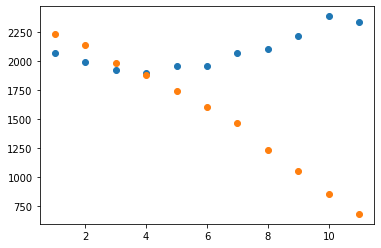

In [15]:
mean_a_error_train = []
mean_a_error_test = []
for idx in range(1, 12):
    tree = DecisionTreeRegressor(max_depth=idx)
    tree.fit(x,y)
    mean_a_error_train.append(mean_absolute_error(y, tree.predict(x)))
    mean_a_error_test.append(mean_absolute_error(y_test, tree.predict(x_test)))
plt.scatter(range(1, 12), mean_a_error_test)
plt.scatter(range(1, 12), mean_a_error_train)
plt.show()

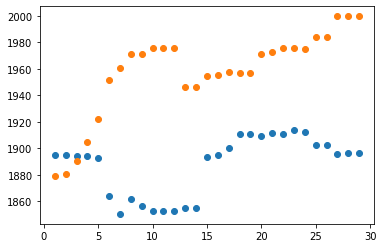

In [16]:
mean_a_error_train = []
mean_a_error_test = []
for idx in range(1, 30):
    tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=idx)
    tree.fit(x,y)
    mean_a_error_train.append(mean_absolute_error(y, tree.predict(x)))
    mean_a_error_test.append(mean_absolute_error(y_test, tree.predict(x_test)))
plt.scatter(range(1, 30), mean_a_error_test)
plt.scatter(range(1, 30), mean_a_error_train)
plt.show()

Na pomarańczowo jest zaznaczone MAE zbioru trenującego, a na niebiesko zbioru testowego.

Najlepszy wynik jest dla drzewa o głębokości 4

In [17]:
tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=7)
tree.fit(x,y)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, tree.predict(x)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, tree.predict(x_test)))

błąd doapsowania do danych uczących: 1960.8265242317234
błąd dopasowania do danych testowych:  1850.6399359961913


## Las losowy

In [18]:
forest = RandomForestRegressor(n_estimators=500,
                              criterion='mse',
                              random_state=1,
                              n_jobs=-1,
                              min_samples_leaf=2)
forest.fit(x,y)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, forest.predict(x)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, forest.predict(x_test)))

błąd doapsowania do danych uczących: 1127.0930305351342
błąd dopasowania do danych testowych:  1857.7723714863716


## Wzmacnianie gradientowe

In [19]:
gbrt = GradientBoostingRegressor(max_depth=5, n_estimators=80)
gbrt.fit(x, y)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, gbrt.predict(x)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, gbrt.predict(x_test)))

błąd doapsowania do danych uczących: 1122.0399424401287
błąd dopasowania do danych testowych:  1910.2213868540764


## Sieć neuronowa

### Zdefiniowanie modelu keras

In [20]:
n_features = 8
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(20, input_dim=n_features, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

### Skompilowanie modelu

In [21]:
model.compile(loss='mse', optimizer='adam')

In [36]:
model.fit(x, y, epochs=50, batch_size=32, verbose=2)
print("błąd doapsowania do danych uczących:", mean_absolute_error(y, model.predict(x)))
print("błąd dopasowania do danych testowych: ", mean_absolute_error(y_test, model.predict(x_test)))

Epoch 1/50
23/23 - 0s - loss: 7525148.5000
Epoch 2/50
23/23 - 0s - loss: 7553048.5000
Epoch 3/50
23/23 - 0s - loss: 7475919.5000
Epoch 4/50
23/23 - 0s - loss: 7661119.0000
Epoch 5/50
23/23 - 0s - loss: 7637231.0000
Epoch 6/50
23/23 - 0s - loss: 7654941.0000
Epoch 7/50
23/23 - 0s - loss: 7657016.5000
Epoch 8/50
23/23 - 0s - loss: 7660393.0000
Epoch 9/50
23/23 - 0s - loss: 7514927.5000
Epoch 10/50
23/23 - 0s - loss: 7508771.5000
Epoch 11/50
23/23 - 0s - loss: 7521346.5000
Epoch 12/50
23/23 - 0s - loss: 7585417.0000
Epoch 13/50
23/23 - 0s - loss: 7848120.0000
Epoch 14/50
23/23 - 0s - loss: 7714915.5000
Epoch 15/50
23/23 - 0s - loss: 7568259.0000
Epoch 16/50
23/23 - 0s - loss: 7553737.5000
Epoch 17/50
23/23 - 0s - loss: 7549704.5000
Epoch 18/50
23/23 - 0s - loss: 7605648.0000
Epoch 19/50
23/23 - 0s - loss: 7721844.5000
Epoch 20/50
23/23 - 0s - loss: 7621056.5000
Epoch 21/50
23/23 - 0s - loss: 7530580.0000
Epoch 22/50
23/23 - 0s - loss: 7612533.5000
Epoch 23/50
23/23 - 0s - loss: 7597354.00